In [5]:
import tensorflow as tf
from tensorflow import keras
import cv2
import numpy as np
import pandas as pd
from google.colab.patches import cv2_imshow

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.applications.vgg16 import VGG16

from ann_visualizer.visualize import ann_viz  


import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

import pickle

#import import_ipynb
#import recognize_chess_board

In [ ]:
! pip install import_ipynb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# V4 dataset contains 100000 images

!unzip "/content/drive/MyDrive/ChessProject/ChessPiecesDatasetV4.zip" -d "/content"

Archive:  /content/drive/MyDrive/ChessProject/ChessPiecesDatasetV4.zip
replace /content/ChessPiecesDatasetV4/test/blackBishop/1b1B1Qr1-7p-6r1-2P5-4Rk2-1K6-4B3-8--(0,1).jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
classes_names = ['blackBishop', 'blackKing', 'blackKnight', 'blackPawn', 'blackQueen', 'blackRook', 'emptyCell', 'whiteBishop', 'whiteKing', 'whiteKnight', 'whitePawn', 'whiteQueen', 'whiteRook' ]

classes_dict = {
    "blackRook" : "r",
    "whiteRook" : "R",
    "blackBishop" : "b",
    "whiteBishop" : "B",
    "blackKnight" : "n",
    "whiteKnight" : "N",
    "blackKing": "k",
    "whiteKing": "K",
    "blackQueen": "q",
    "whiteQueen": "Q",
    "blackPawn": "p",
    "whitePawn": "P",
    "emptyCell": "-"
}

In [ ]:
def load_image_dataset(dataset_path):
  return image_dataset_from_directory(
    dataset_path,
    labels='inferred',
    label_mode='categorical',
    image_size=[50, 50],
    interpolation='nearest',
    batch_size=150,
    shuffle=True
)

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

def convert_to_float(image, label):
  image = tf.image.convert_image_dtype(image, dtype=tf.float32)
  return image, label

def normalize_images(dataset):
  return (
    dataset
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
  )



In [ ]:
train_ds_path = '/content/ChessPiecesDatasetV4/train'
test_ds_path = '/content/ChessPiecesDatasetV4/test'
validation_ds_path = '/content/ChessPiecesDatasetV4/validation'

# load train set
train_dataset = load_image_dataset(train_ds_path)

# load test set
test_dataset = load_image_dataset(test_ds_path)

# load validation set
validation_dataset = load_image_dataset(validation_ds_path)

Found 80000 files belonging to 13 classes.
Found 9984 files belonging to 13 classes.
Found 9984 files belonging to 13 classes.


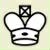

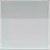

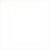

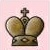

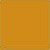

In [ ]:
first_batch = train_dataset.take(1)

for images, labels in first_batch:
    for i in range(5):
        #ax = plt.subplot(6, 6, i + 1)
        im = cv2.cvtColor(images[i].numpy().astype("uint8"), cv2.COLOR_BGR2RGB)
        cv2_imshow(im)
        #plt.title(class_names[labels[i]])
        #plt.axis("off")

In [ ]:
# normalize training images
train_dataset = normalize_images(train_dataset)

# normalize test images
test_dataset = normalize_images(test_dataset)

# normalize validaiton images
validation_dataset = normalize_images(validation_dataset)

In [ ]:
# not used in model
pretrained_base = VGG16(weights='imagenet', include_top=False, input_shape=(50,50,3))
pretrained_base.summary()
pretrained_base.trainable = False

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 50, 50, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 50, 50, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 25, 25, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 25, 25, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 25, 25, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [ ]:
# model
class ChessNeuralNetwork:

  @staticmethod
  def makeModel():
    model = Sequential()

   # data augmentation
   #model.preprocessing.RandomContrast(factor=0.5)
   #model.preprocessing.RandomFlip(mode='horizontal')
   #model.preprocessing.RandomTranslation(heigth_factor=0.1, width_factor=0.1)

    #model.add(pretrained_base)

    model.add(BatchNormalization(renorm=True))
    model.add(Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'))

    model.add(Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'))
    model.add(GlobalMaxPooling2D())
    model.add(Dropout(0.4))

    model.add(BatchNormalization(renorm=True))
    model.add(Dense(13, activation='softmax'))

    return model

  @staticmethod
  def compileModel(model):
    optimizer = Adam(epsilon=0.001)

    model.compile(
      optimizer=optimizer,
      loss='categorical_crossentropy',
      metrics=['categorical_accuracy']
      )
    
  @staticmethod
  def getEarlyStopping():
    return EarlyStopping(
      min_delta=0.001,
      patience=5,
      restore_best_weights=True
    )
    


In [ ]:
epochs=15

model = ChessNeuralNetwork.makeModel()
ChessNeuralNetwork.compileModel(model)
early_stopping = ChessNeuralNetwork.getEarlyStopping()

# model training

history = model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=epochs,
  callbacks=[early_stopping]
)


Epoch 1/15
534/534 [==============================] - 106s 196ms/step - loss: 0.5091 - categorical_accuracy: 0.8775 - val_loss: 0.0883 - val_categorical_accuracy: 0.9787
Epoch 2/15
534/534 [==============================] - 106s 198ms/step - loss: 0.1146 - categorical_accuracy: 0.9643 - val_loss: 0.0251 - val_categorical_accuracy: 0.9942
Epoch 3/15
534/534 [==============================] - 107s 200ms/step - loss: 0.0570 - categorical_accuracy: 0.9826 - val_loss: 0.0220 - val_categorical_accuracy: 0.9958
Epoch 4/15
534/534 [==============================] - 107s 201ms/step - loss: 0.0385 - categorical_accuracy: 0.9876 - val_loss: 0.0104 - val_categorical_accuracy: 0.9978
Epoch 5/15
534/534 [==============================] - 107s 200ms/step - loss: 0.0368 - categorical_accuracy: 0.9882 - val_loss: 0.0075 - val_categorical_accuracy: 0.9990
Epoch 6/15
534/534 [==============================] - 107s 200ms/step - loss: 0.0255 - categorical_accuracy: 0.9924 - val_loss: 0.0050 - val_categoric

In [8]:
#pickle.dump(model, open('/content/drive/MyDrive/ChessProject/model.pickle', 'wb'))
model = pickle.load(open('/content/drive/MyDrive/ChessProject/model.pickle', 'rb'))

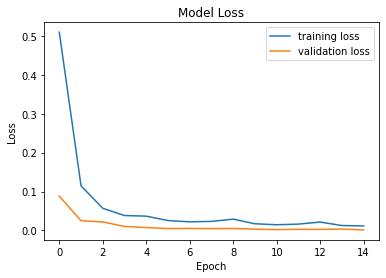

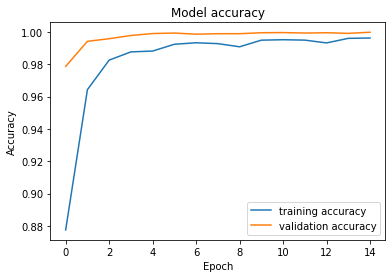

Minimum validation loss: 0.0014832430751994252


In [ ]:
history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training loss', 'validation loss'])
plt.show()

history_frame.loc[:, ['categorical_accuracy', 'val_categorical_accuracy']].plot()
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training accuracy', 'validation accuracy'])
plt.show()

print("Minimum validation loss: {}".format(history_frame['val_loss'].min()))

In [ ]:
def get_labels_from_dataset(dataset, batched=False):
  labels = list(map(lambda x: x[1], dataset)) # get labels

  if not batched:
    return tf.concat(labels, axis=0) #concat the list of batched labels

  return labels


def print_classification_report(predictions):
  test_labels = get_labels_from_dataset(test_dataset)
  y_true = np.argmax(test_labels,axis=1)
  y_pred = np.argmax(predictions, axis=1)

  print(classification_report(
    y_true, # test_labels.argmax(axis=1),
    y_pred, # predictions.argmax(axis=1),
    target_names=classes_names,
    digits=4
  ))

  print("total accuracy",accuracy_score(y_true, y_pred))

In [ ]:
predictions = model.predict(test_dataset)

print_classification_report(predictions)

              precision    recall  f1-score   support

 blackBishop     1.0000    1.0000    1.0000       220
   blackKing     0.9936    1.0000    0.9968       156
 blackKnight     1.0000    1.0000    1.0000       142
   blackPawn     1.0000    0.9922    0.9961       129
  blackQueen     1.0000    0.9821    0.9910        56
   blackRook     0.9934    1.0000    0.9967       150
   emptyCell     1.0000    1.0000    1.0000      8248
 whiteBishop     1.0000    1.0000    1.0000       225
   whiteKing     1.0000    1.0000    1.0000       156
 whiteKnight     1.0000    1.0000    1.0000       149
   whitePawn     1.0000    1.0000    1.0000       148
  whiteQueen     1.0000    1.0000    1.0000        69
   whiteRook     1.0000    1.0000    1.0000       136

    accuracy                         0.9998      9984
   macro avg     0.9990    0.9980    0.9985      9984
weighted avg     0.9998    0.9998    0.9998      9984

total accuracy 0.9997996794871795


/content/drive/MyDrive/ChessProject
importing Jupyter notebook from recognize_chess_board.ipynb
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


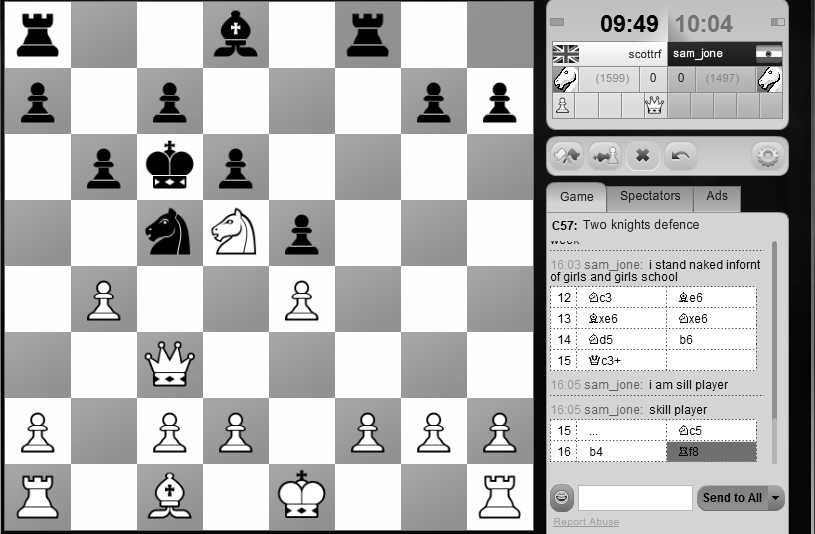

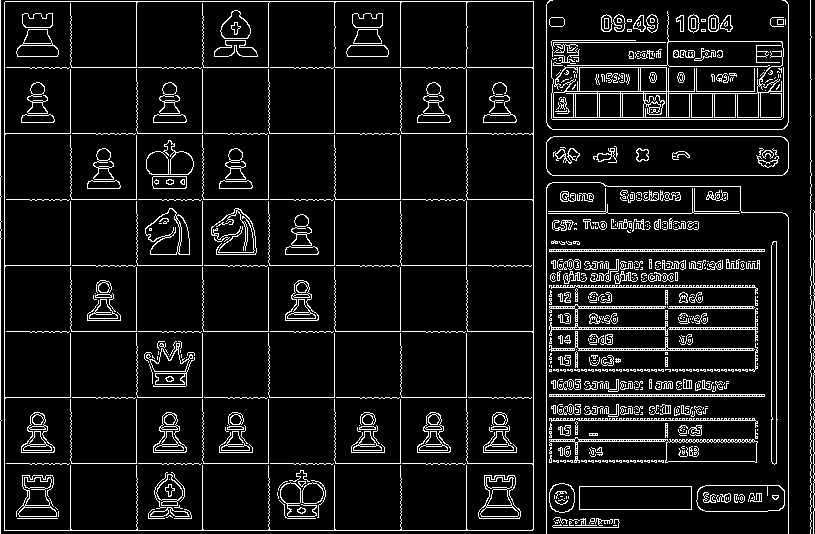

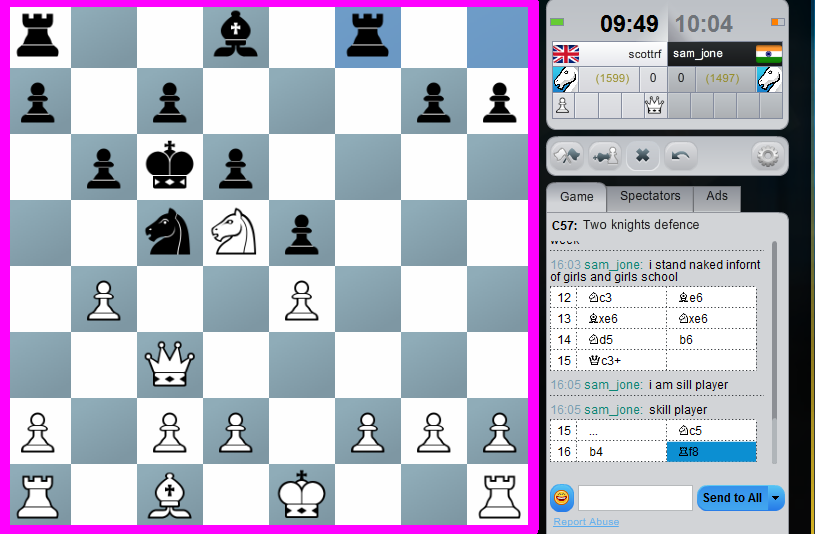

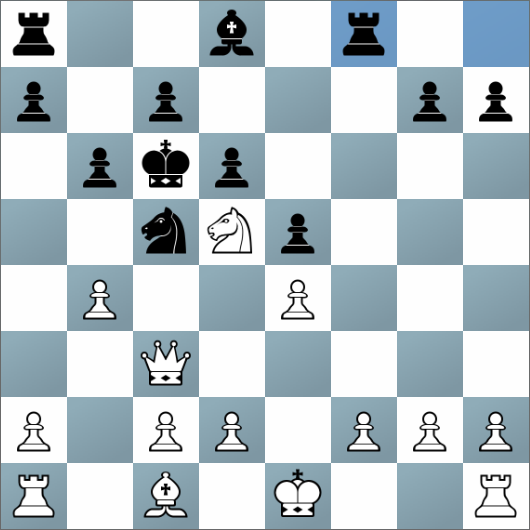

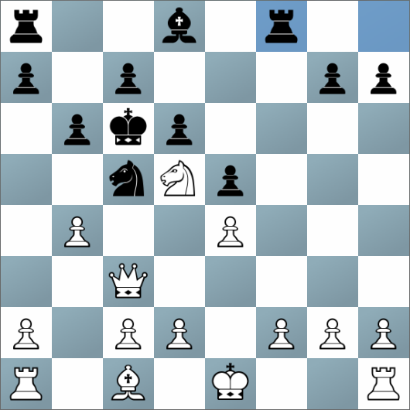

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')
%cd "/content/drive/MyDrive/ChessProject"

import import_ipynb
import recognize_chess_board

img = cv2.imread("/content/drive/MyDrive/ChessProject/SimpleImages/s18.png")
cropped_image = recognize_chess_board.find_chess_board(img)

In [ ]:
def get_chess_pieces_positions(board_image):
  #intialize chess pieces matrix
  board = np.zeros((8,8), 'U1')

  stepX = board_image.shape[1] // 8
  stepY = board_image.shape[0] // 8

  for y in range(0, 8):

    row = []
    for x in range(0, 8):

      startX = x * stepX
      startY = y * stepY
      endX = (x + 1) * stepX
      endY = (y + 1) * stepY

      row.append((startX, startY, endX, endY))

      cell = board_image[startY:endY, startX:endX]
      
      if cell is not None:

        resized_cell = cv2.resize(cell, (50, 50))
        resized_cell = resized_cell.astype("float") / 255.0
        resized_cell = np.expand_dims(resized_cell, axis=0)
        

        pred = model.predict(resized_cell)
        pred = classes_names[np.argmax(pred)]
        board[y, x] = classes_dict[pred]
      
  return board

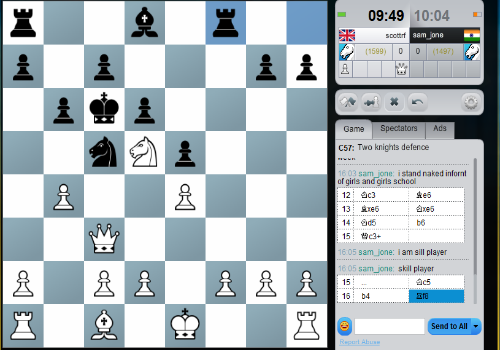

[['r' '-' '-' 'b' '-' 'r' '-' '-']
 ['p' '-' 'p' '-' '-' '-' 'p' 'p']
 ['-' 'p' 'k' 'p' '-' '-' '-' '-']
 ['-' '-' 'n' 'N' 'p' '-' '-' '-']
 ['-' 'P' '-' '-' 'P' '-' '-' '-']
 ['-' '-' 'Q' '-' '-' '-' '-' '-']
 ['P' '-' 'P' 'P' '-' 'P' 'P' 'P']
 ['R' '-' 'B' '-' 'K' '-' '-' 'R']]


In [ ]:
# input
resized_input = cv2.resize(img, (500, 350))
cv2_imshow(resized_input)
# output
board_matrix = get_chess_pieces_positions(cropped_image)
print(board_matrix)